In [1]:
from pylab import *
from scipy import *
from matplotlib.colors import LogNorm
from matplotlib import colors
from IPython.display import Image
from scipy.integrate import quad
from scipy import interpolate
from scipy.special import jn, gamma
from scipy.misc import derivative
from scipy.integrate import nquad
import camb
from camb import model, initialpower

In [2]:
## cosmology WMAP9
h = 0.7
H0 = h*100
ob = 0.046
oc = 0.236
om = ob+oc
ol = 1-om#0.718
ns = 0.9646
s8 = 0.817

In [3]:
### power spectrum from camb
zarr = linspace(0,2,5)
pars = camb.CAMBparams()
pars.set_cosmology(H0=70, ombh2=ob*h**2, omch2=oc*h**2)
pars.InitPower.set_params(ns=0.965)
pars.set_matter_power(redshifts=zarr, kmax=10.0)
results = camb.get_results(pars)
pars.NonLinear = model.NonLinear_both
results.calc_power_spectra(pars)
kh_nonlin, z_nonlin, pk_nonlin = results.get_matter_power_spectrum(minkh=1e-6, maxkh=100.0, npoints = 500)

Note: redshifts have been re-sorted (earliest first)


In [4]:
Pmatter_z0_interp = interpolate.interp1d(log(kh_nonlin), pk_nonlin[0],fill_value='extrapolate')
Pmatter_z0 = lambda k: Pmatter_z0_interp(log(k))

In [5]:
rp, PI = 5.,5.

kabs = lambda kz, kp: sqrt(kz**2+kp**2)

#betaD = finterp(0.0)/bD
#print betaD

#xi_gp = lambda kz,kp,rp,PI,z:cos(kz*PI)*kp**3/(kp**2+kz**2)*Pmatter2(kabs(kz,kp),z)*jn(2,kp*rp)*(1.0+betaD*kz**2/(kp**2+kz**2))
xi_gp = lambda kz,kp,rp,PI,z:cos(kz*PI)*kp**3/(kp**2+kz**2)*Pmatter_z0(kabs(kz,kp))*jn(2,kp*rp)

nbin=501 ####### similar answer between 500-5000 bins
ik = logspace(-4, 1,nbin)
#ik = linspace(1e-4, 10, nbin)
dk = ik[1:]-ik[:-1]
ikc = 0.5*(ik[1:]+ik[:-1])
kz, kp = array(meshgrid(ikc,ikc)).reshape(2,-1)
dkz, dkp = array(meshgrid(dk,dk)).reshape(2,-1)

def xi_int (rp, PI, z=0):
    xi_arr = xi_gp(kz,kp,rp,PI,z)
    out = sum(xi_arr*dkz*dkp)
    return out
print 'brute force:',xi_int(rp, PI)

brute force: 6.99590996219


In [6]:
## 2/14-3/5 try marko's fft method for k*Pk
Nk=1501

#kk2=kh_nonlin
#kPk = pk_nonlin[0]*kh_nonlin
kk2 = logspace(-4,1,Nk)
kPk = kk2*Pmatter_z0(kk2)
Nk=len(kPk) ## number of bins
kPk_fft = fft(kPk) ## FFT
klogstep = log(kk2[1]/kk2[0])
#print klogstep
########## now compare how accurate marko's integration is
kmin,kmax=kk2[[0,-1]]
ifreq = fftfreq(Nk)##
nu_arr = 1j*2*pi*fftfreq(Nk, d=klogstep) ## the argument goes into k^nu_n, now nu_n is nu_arr
cn = kPk_fft*kmin**(-nu_arr) ## the fourier coefficients

############# test inverse fft
#dfreq = ifreq[1]-ifreq[0]
#kPk_ifft = array([sum(kPk_fft*exp(1j*2*pi*logk*ifreq))*dfreq for logk in arange(Nk)])
### because Pk = sum Pnu * exp(i 2pi logk nu) dnu

############## test marko method
### inverse FFT, has 1/N in it: http://mathworld.wolfram.com/DiscreteFourierTransform.html
kPk_marko = array([sum(cn*k**nu_arr)/Nk for k in kk2])

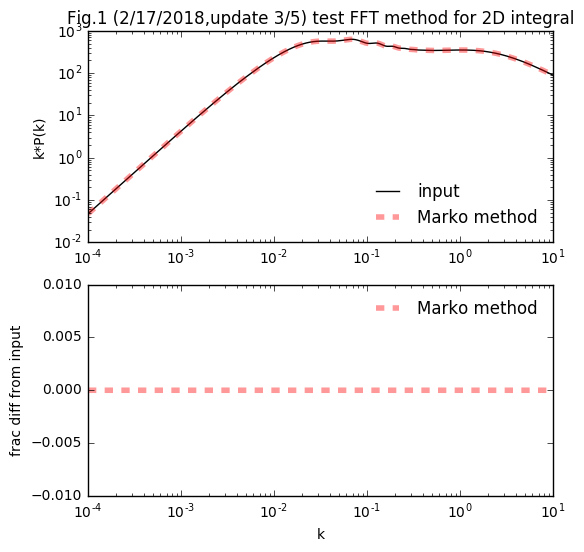

In [23]:
################## plotting  Marko fft test
f, (ax, ax2)=subplots(2,1,figsize=(6,6))
ax.plot(kk2, kPk,'k-',label='input')
#ax.plot(kk2, Pk_ifft, 'b-',lw=8,alpha=0.3, label='ifft(fft(Pk))')
ax.plot(kk2, real(kPk_marko),'r--',lw=4, alpha=0.4 , label='Marko method')
ax.set_xscale('log')
ax.set_ylabel('k*P(k)')
ax.set_yscale('log')
ax.legend(frameon=0,loc=0)
ax.set_title('Fig.1 (2/17/2018,update 3/5) test FFT method for 2D integral')
#ax2.plot(kk2, Pk_ifft/kPk-1, 'b-',lw=8, alpha=0.3, label='ifft(fft(Pk))')
ax2.plot(kk2, kPk_marko/kPk-1, 'r--',lw=4, alpha=0.4 ,label='Marko method')
ax2.set_xscale('log')
ax2.set_ylim(-0.01,0.01)
ax2.set_xlabel('k')
ax2.set_ylabel('frac diff from input')
ax2.legend(frameon=0,loc=0)
show()

In [8]:
def test_kbins(rp, PI, Nk=1001):

    kk2 = logspace(-4,1,Nk)
    kPk = kk2*Pmatter_z0(kk2)
    Nk=len(kPk) ## number of bins
    kPk_fft = fft(kPk) ## FFT
    klogstep = log(kk2[1]/kk2[0])
    #print klogstep
    ########## now compare how accurate marko's integration is
    kmin,kmax=kk2[[0,-1]]
    ifreq = fftfreq(Nk)##
    nu_arr = 1j*2*pi*fftfreq(Nk, d=klogstep) ## the argument goes into k^nu_n, now nu_n is nu_arr
    cn = kPk_fft*kmin**(-nu_arr)
    fun_marko = lambda rp, PI, nu: rp**2/(rp**2+PI**2)**(2.0+nu/2.0)*cos(pi*nu/2.0)*gamma(3.0+nu)/(1-nu**2)
    xi_int_marko = lambda rp, PI: sum(cn*fun_marko(rp, PI, nu_arr))/Nk
    return xi_int_marko(rp, PI)

#fun_marko = lambda rp, PI, nu: rp**2/(rp**2+PI**2)**(3.0+nu/2.0)*cos(pi*nu/2.0)*gamma(3.0+nu)*( (nu-3.0)*(rp**2+PI**2)+ (rp**2-(3+nu)*PI**2*betaD))/(nu-3.0)/(nu**2-1)

for Nk in (500, 600,1000,1500,1650,1700,2000):
    print Nk,test_kbins(rp, PI, Nk)

500 (6.3263448242-0.0106701626355j)
600 (6.41354307447-0.00697514352184j)
1000 (6.59892705127+0.00901410413124j)
1500 (6.72833505636+0.00734859208041j)
1650 (6.76106194586+0.0017448883358j)
1700 (nan+nan*j)
2000 (nan+nan*j)


/Users/jia/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:14: RuntimeWarning: overflow encountered in cos
/Users/jia/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:14: RuntimeWarning: invalid value encountered in multiply
/Users/jia/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:14: RuntimeWarning: invalid value encountered in divide


In [10]:
PI_arr=logspace(-0.5, 1, 50)
rp_arr = [1.0, 2.0, 5.0, 10.0, 20.0, 40.0]
brute_arr = array([[xi_int(irp, iPI) for iPI in PI_arr] for irp in rp_arr])

In [11]:
marko_arr = array([[test_kbins(irp, iPI, Nk=1650) for iPI in PI_arr] for irp in rp_arr])

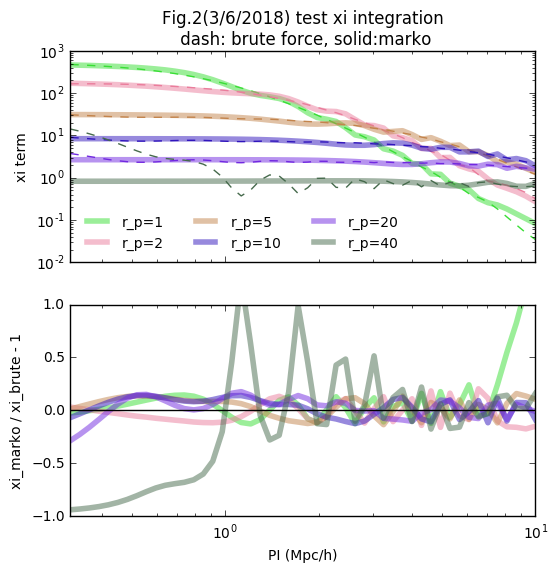

In [22]:
f,(ax,ax2)=subplots(2,1,sharex=True,figsize=(6,6))
i=0
seed(5)
for irp in rp_arr:
    icolor=rand(3)
    ax.plot(PI_arr,brute_arr[i],'--',color=icolor,)
    ax.plot(PI_arr,marko_arr[i],'-',lw=4, alpha=0.5,color=icolor,label='r_p=%i'%(irp))
    ax2.plot(PI_arr,marko_arr[i]/brute_arr[i]-1,'-',lw=4, alpha=0.5, color=icolor)
    i+=1
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(amin(PI_arr),amax(PI_arr))
ax2.set_xlabel('PI (Mpc/h)')
ax.set_ylabel('xi term')
ax2.set_ylabel('xi_marko / xi_brute - 1')
ax2.set_ylim(-1,1)
ax2.plot(PI_arr,zeros(len(PI_arr)),'k-')
ax.legend(frameon=0,fontsize=10,loc=0,ncol=3)
ax.set_title('Fig.2(3/6/2018) test xi integration\n dash: brute force, solid:marko')
show()